### remove very low MIC value

In [1]:
cd ../../src

/Users/in-divye.singh/Documents/Projects/MIC_predictor/src


In [2]:
import biovec
import numpy as np
import pandas as pd
from itertools import chain, combinations
from collections import Counter

from utils import *

from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

from Bio.SeqUtils.ProtParam import ProteinAnalysis

In [3]:
import seaborn as sns

In [4]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)

In [5]:
avp_ic50 = pd.read_csv("../data/raw/AVP-IC50Pred_train.csv")
ha_avp = pd.read_csv("../data/raw/HA_AVP.csv")

In [6]:
df = pd.concat([avp_ic50[['Sequence','MIC']], ha_avp], axis=0).drop_duplicates(['Sequence']).reset_index(drop=True)
df = sequence_filtering(df)

In [9]:
df2 = df[df['MIC'] >= 1e-3]

In [10]:
df2

,Sequence,MIC
0,AAQRRGRVGRNPNQVGD,442.00000
1,HRILARIRQMMT,435.50000
2,RNPSQVGD,383.00000
3,RVGRNPNQVGD,374.00000
4,AAQRRGRIGRNPSQVGD,358.00000
...,...,...
706,SLDQINVTFLDLEYEMKKLEEAIKKLEESYIDLKEL,0.00130
707,NGAICWGPCPTAFRQIGNCGHFKVRCCKIR,0.11515
708,CFPYITRPGTYHDWWYTRKNRQ,0.30000
709,YTSLIHSLIEESQNQQEKNEQELLELDKWASLWNWF,0.01131


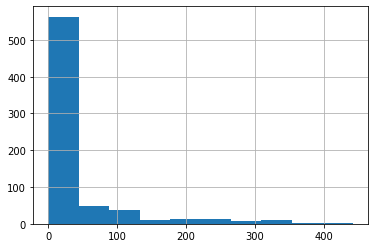

In [11]:
df2['MIC'].hist()

In [14]:
df2['pIC50'] = df2['MIC'].apply(lambda x: -np.log(x*1e-6))

/Users/in-divye.singh/anaconda3/envs/life-science/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [15]:
df2

,Sequence,MIC,pIC50
0,AAQRRGRVGRNPNQVGD,442.00000,7.724201
1,HRILARIRQMMT,435.50000,7.739016
2,RNPSQVGD,383.00000,7.867476
3,RVGRNPNQVGD,374.00000,7.891255
4,AAQRRGRIGRNPSQVGD,358.00000,7.934978
...,...,...,...
706,SLDQINVTFLDLEYEMKKLEEAIKKLEESYIDLKEL,0.00130,20.460902
707,NGAICWGPCPTAFRQIGNCGHFKVRCCKIR,0.11515,15.977030
708,CFPYITRPGTYHDWWYTRKNRQ,0.30000,15.019483
709,YTSLIHSLIEESQNQQEKNEQELLELDKWASLWNWF,0.01131,18.297579


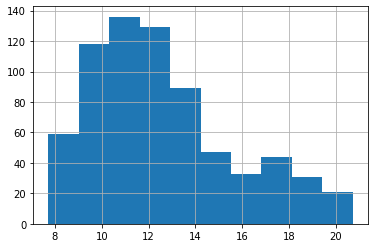

In [16]:
df2['pIC50'].hist()

In [17]:
def get_physicochemical_properties(df):
    params = ['aromaticity', 'helix', 'turn', 'sheet', 'gravy', 'net_charge_at_pH7point4']

    prop = []
    for seq in df.Sequence:
        X = ProteinAnalysis(seq)
        aromaticity = X.aromaticity()
        sec_struc = X.secondary_structure_fraction()
        helix = sec_struc[0]
        turn = sec_struc[1]
        sheet = sec_struc[2]
        gravy = X.gravy() # hydrophobicity related
        net_charge_at_pH7point4 = X.charge_at_pH(7.4)

        prop.append([aromaticity, helix, turn, sheet, gravy, net_charge_at_pH7point4])
    return pd.DataFrame(prop, columns=params)

In [19]:
aa_freq = reduce_by_kmer_frequency(df2, kmer=1)

In [20]:
uniprot_embedding = biovec.models.load_protvec("../data/embeddings/uniprot__kmer_3_contextWindow_10_vector_100_reduction_None")

avg_protvec = convert_sequences_to_avg_vectors(df2['Sequence'], uniprot_embedding, kmer=3)
avg_protvec = avg_protvec.reset_index(drop=True)

/Users/in-divye.singh/anaconda3/envs/life-science/lib/python3.6/site-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
Creating vectors: 100%|██████████| 707/707 [00:00<00:00, 1160.22sequence/s]


In [21]:
physicochemical_prop = get_physicochemical_properties(df2)

In [22]:
X = pd.concat([aa_freq, avg_protvec, physicochemical_prop[['helix','turn','sheet']]], axis=1)

In [23]:
y = df2[['pIC50', 'MIC']]

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
y_train_pmic, y_train_mic = y_train['pIC50'], y_train['MIC']
y_test_pmic, y_test_mic = y_test['pIC50'], y_test['MIC']

In [26]:
from sklearn.model_selection import cross_val_score, GridSearchCV, LeaveOneOut

In [27]:
def multi_objective_score(y_true, y_pred):
    mape = mean_absolute_percentage_error(y_true, y_pred)
    std_diff = abs(np.std(y_pred) - np.std(y_true))
    return mape + 10*std_diff
multi_objective_scorer = make_scorer(multi_objective_score, greater_is_better=False)

In [101]:
svr = SVR(C=10, gamma=6)
cv_score = cross_val_score(svr, X_train, y_train_pmic, cv=5, scoring=mape_scorer)
cv_mean = cv_score.mean()
print(cv_score, cv_mean)

_ = svr.fit(X_train, y_train_pmic)
y_pred = svr.predict(X_test)

print(np.std(y_test_pmic), np.std(y_pred))

y_pred_mic = np.exp(-y_pred)/1e-6
ape_mic = 100*np.abs(y_test_mic-y_pred_mic)/y_test_mic
ape_mic.mean()

[-12.53085857 -11.39680224 -13.98758472 -12.7481263  -14.18575407] -12.969825178188424
2.7423101563508783 2.1660810278910962


1633.8872648764122

In [84]:
ape = 100*np.abs(y_test_pmic-y_pred)/y_test_pmic

In [66]:
y_pred_mic = np.exp(-y_pred)/1e-6

In [67]:
ape_mic = 100*np.abs(y_test_mic-y_pred_mic)/y_test_mic

In [68]:
gg = list(zip(y_test_pmic.round(4), y_pred.round(4), ape, y_test_mic.round(4), y_pred_mic.round(4), ape_mic))

In [69]:
sorted(gg, key=lambda x:x[5])

[(18.9315, 18.9283, 0.01678271003957756, 0.006, 0.006, 0.31822725324860285),
 (12.0238, 12.008, 0.1313888752178657, 6.0, 6.0955, 1.5923317406682032),
 (10.7245, 10.706, 0.17228079138929855, 22.0, 22.4103, 1.8647939555438178),
 (16.5489, 16.5046, 0.2674869979014718, 0.065, 0.0679, 4.526046008945431),
 (12.1162, 12.0116, 0.863838967909559, 5.47, 6.0736, 11.033828810674814),
 (9.8191, 9.9462, 1.29346035784968, 54.4, 47.9116, 11.927228661720285),
 (12.7004, 12.8532, 1.2032762922874154, 3.05, 2.6178, 14.17162548113767),
 (7.8675, 8.0337, 2.112996915825934, 383.0, 324.341, 15.31566227448391),
 (13.7763, 13.9511, 1.268745032314012, 1.04, 0.8732, 16.036331036392166),
 (12.8992, 12.7497, 1.1588972061889768, 2.5, 2.9031, 16.12403466139556),
 (8.8597, 9.0787, 2.47178762325799, 142.0, 114.0725, 19.667230528873784),
 (10.6602, 10.8868, 2.125322284217513, 23.46, 18.7039, 20.273160287134527),
 (8.5374, 8.3211, 2.5340601064072974, 196.0, 243.3395, 24.1527831799332),
 (12.7169, 12.5002, 1.7036823244704

### Leave one out CV

In [102]:
loo = LeaveOneOut()

In [103]:
from tqdm import tqdm

In [108]:
result_df = pd.DataFrame(columns = list(df2.columns)+["y_pred_pmic", "y_pred_mic", "ape_pmic", "ape_mic"])
for train_index, test_index in tqdm(loo.split(X)):
    X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    y_train_pmic, y_train_mic = y_train['pIC50'], y_train['MIC']
    y_test_pmic, y_test_mic = y_test['pIC50'], y_test['MIC']
    svr = SVR(C=10, gamma=6)
    _ = svr.fit(X_train, y_train_pmic)
    y_pred_pmic = svr.predict(X_test)
    y_pred_mic = np.exp(-y_pred_pmic)/1e-6
    ape = 100*np.abs(y_test_pmic-y_pred_pmic)/y_test_pmic
    ape_mic = 100*np.abs(y_test_mic-y_pred_mic)/y_test_mic
    df_val = df2.iloc[test_index,:].values[0].tolist()
    res = np.append(df_val, [y_pred_pmic[0], y_pred_mic[0], ape.values[0], ape_mic.values[0]])
    res = pd.DataFrame([res], columns = list(df2.columns)+["y_pred_pmic", "y_pred_mic", "ape_pmic", "ape_mic"])
    result_df = result_df.append(res)
result_df = result_df[["Sequence", "pIC50", "y_pred_pmic", "ape_pmic", "MIC", "y_pred_mic", "ape_mic"]]

707it [00:57, 12.26it/s]


In [109]:
result_df#.to_csv("../results/SVM_pMIC_to_MIC_removed_less_than_1e-6_rbf_c_10_gamma_10.csv", index=False)

,Sequence,pIC50,y_pred_pmic,ape_pmic,MIC,y_pred_mic,ape_mic
0,AAQRRGRVGRNPNQVGD,7.724200675886576,8.26022114022038,6.9394942833004665,442.0,258.6017976398749,41.4928059638292
0,HRILARIRQMMT,7.739015761671717,10.53829536269862,36.17100271187748,435.5,26.50186731603407,93.91461140848817
0,RNPSQVGD,7.867475568783628,8.816235209360261,12.059263893250563,383.0,148.30565025757193,61.2778981050726
0,RVGRNPNQVGD,7.891254760549742,8.571679289679329,8.622513779826127,374.0,189.39433466347654,49.359803565915364
0,AAQRRGRIGRNPSQVGD,7.934977571563574,8.760039904790803,10.397790362810714,358.0,156.87834826394578,56.17923232850677
...,...,...,...,...,...,...,...
0,SLDQINVTFLDLEYEMKKLEEAIKKLEESYIDLKEL,20.46090157247892,12.631352607598163,38.26590405679849,0.0013,3.2679339000362737,251279.53077202104
0,NGAICWGPCPTAFRQIGNCGHFKVRCCKIR,15.977030210679716,10.555899407761911,33.93077894597767,0.11515,26.039409754415942,22513.469174481932
0,CFPYITRPGTYHDWWYTRKNRQ,15.01948336229021,11.45078447849528,23.760463643875735,0.3,10.641123596032811,3447.0411986776035
0,YTSLIHSLIEESQNQQEKNEQELLELDKWASLWNWF,18.297578546818382,18.055802317862494,1.3213564206720085,0.011309999999999999,0.014403388898737745,27.350918644896083


In [110]:
result_df['ape_pmic'].astype('float').mean()

11.964346298022491

In [111]:
result_df['ape_mic'].astype('float').mean()

3459.802978955599

In [ ]:
params2 = ['molecular_weight', 'aromaticity', 'instability_index',
          'isoelectric_point', 'helix', 'turn', 'sheet', 'with_reduced_cysteines',
          'with_disulfid_bridges', 'gravy', 'net_charge_at_pH7point4']

In [ ]:
prop2 = []
for seq in df2.Sequence:
    X = ProteinAnalysis(seq)
    molecular_weight = X.molecular_weight()
    aromaticity = X.aromaticity()
    instability_index = X.instability_index()
    isoelectric_point = X.isoelectric_point()
    sec_struc = X.secondary_structure_fraction()
    helix = sec_struc[0]
    turn = sec_struc[1]
    sheet = sec_struc[2]
    epsilon_prot = X.molar_extinction_coefficient()
    with_reduced_cysteines = epsilon_prot[0]
    with_disulfid_bridges = epsilon_prot[1]
    gravy = X.gravy() # hydrophobicity related
    # flexibility = X.flexibility()
    # X.protein_scale()
    net_charge_at_pH7point4 = X.charge_at_pH(7.4)

    prop2.append([seq, molecular_weight, aromaticity, instability_index, isoelectric_point, helix, turn, sheet,
                 with_reduced_cysteines, with_disulfid_bridges, gravy, net_charge_at_pH7point4])
prop2 = pd.DataFrame(prop2, columns=["Sequence"]+params2)

In [ ]:
prop2

In [ ]:
prop2.merge(result_df,on=['Sequence'],how='left')

In [ ]:
a = set(df2['Sequence'])

In [ ]:
b = set(result_df['Sequence'])

In [ ]:
a.intersection(b)